In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import AISMapPlot as aismap

In [2]:
ais_learners = []
sectors = [0, 1, 2]
sector_borders = [2.2, 3.20, 3.94]
positions = pd.DataFrame([[np.nan, 2.2], [np.nan, 3.2], [np.nan, 3.94]],
                         columns = ['Latitude', 'Longitude'])


for s in sectors:
    ais_learners.append(pd.read_pickle('FEL-ROT_learners_01min_s%d.pkl' % (s)))

In [3]:
positions

,Latitude,Longitude
0,NaN,2.20
1,NaN,3.20
2,NaN,3.94


In [4]:
ais_learners[0].head()

,TripID,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,...,hour_of_day,weekday,day_of_month,month,sector,mins_to_sector_leave,sector_leave_lat,sector_leave_lon,sector_leave_sog,sector_leave_cog
336698,1000064,2016-03-14 23:40:00,82.0,11.0,3.04,52.03,1.69,8.1,88.0,76.0,...,23,0,14,3,0,136.615385,52.0,2.2,9.130769,99.1
336699,1000064,2016-03-14 23:41:00,82.0,11.0,3.04,52.03,1.70,8.2,88.1,77.0,...,23,0,14,3,0,135.615385,52.0,2.2,9.130769,99.1
336700,1000064,2016-03-14 23:42:00,82.0,11.0,3.04,52.03,1.70,8.3,90.1,78.0,...,23,0,14,3,0,134.615385,52.0,2.2,9.130769,99.1
336701,1000064,2016-03-14 23:43:00,82.0,11.0,3.04,52.03,1.70,8.5,88.7,76.0,...,23,0,14,3,0,133.615385,52.0,2.2,9.130769,99.1
336533,1000064,2016-03-14 23:44:00,82.0,11.0,3.04,52.03,1.71,8.2,87.9,77.0,...,23,0,14,3,0,132.615385,52.0,2.2,9.130769,99.1


In [13]:
X = []
y = []
for s in sectors:
    X.append(ais_learners[s][['Latitude', 'Longitude', 'COG', 'SOG']])
    y.append(ais_learners[s][['sector_leave_lat', 'sector_leave_lon', 'mins_to_sector_leave', 'sector_leave_cog', 'sector_leave_sog']])

In [14]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

cv_splits = []
for s in sectors:
    cv_splits.append(list(GroupKFold(n_splits = 10).split(X[s], y[s], groups = ais_learners[s]['TripID'])))

In [15]:
# Retrieve ONE simple train-test split (for each sector)
train_indices = []
test_indices = []
for s in sectors:
    a, b = cv_splits[s][0]
    train_indices.append(a)
    test_indices.append(b)

X_train = []
X_test = []
for s in sectors:
    X_train.append(X[s].iloc[train_indices[s]])
    X_test.append(X[s].iloc[test_indices[s]])

y_train = []
y_test = []
for s in sectors:
    y_train.append(y[s].iloc[train_indices[s]])
    y_test.append(y[s].iloc[test_indices[s]])

In [8]:
from sklearn.neighbors import KNeighborsRegressor

for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 20)
    scores = cross_val_score(knn_pos, X[s], y[s], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print(scores.mean())

-4.71579683735
-5.28787357858
-4.49011634774


In [43]:
#3.40111799045

from sklearn.neighbors import KNeighborsRegressor

for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors =7, weights ='distance', leaf_size= 30)
    scores = cross_val_score(knn_pos, X[s], y[s], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print(scores.mean())

-3.56238172187
-3.40725918426
-3.26612290128


In [31]:
from sklearn.neighbors import KNeighborsRegressor

for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 10, algorithm= 'kd_tree', weights= 'distance', leaf_size= 30)
    scores = cross_val_score(knn_pos, X[s], y[s], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print(scores.mean())

-3.55257749499
-3.43293131764
-3.24650179491


In [44]:
knn_pos_list = []
for s in sectors:
    knn_pos = KNeighborsRegressor(n_neighbors = 10, algorithm= 'kd_tree', weights= 'distance', leaf_size= 30)
    knn_pos.fit(X_train[s], y_train[s]['sector_leave_lat'])
    knn_pos_list.append(knn_pos)

In [61]:
knn_course_list = []
for s in sectors:
    knn_course = KNeighborsRegressor(n_neighbors = 10, algorithm= 'kd_tree', weights= 'distance', leaf_size= 30)
    knn_course.fit(X_train[s], y_train[s]['sector_leave_cog'])
    knn_course_list.append(knn_course)

In [62]:
knn_speed_list = []
for s in sectors:
    knn_speed = KNeighborsRegressor(n_neighbors = 10, algorithm= 'kd_tree', weights= 'distance', leaf_size= 30)
    knn_speed.fit(X_train[s], y_train[s]['sector_leave_sog'])
    knn_speed_list.append(knn_speed)

In [50]:
knn_pos_list[1].predict([[51.88, 2.88, 84.0, 15.8]])

array([ 51.92718176])

In [11]:
# 51.99 4.07
lats = [52.03]
lons = [1.70]
for s in sectors:
    lat = knn_pos_list[s].predict([[lats[-1], lons[-1]]])[0]
    lon = sector_borders[s]
    lats.append(lat)
    lons.append(lon)
print(lats)
print(lons)

[52.03, 51.999999999999986, 52.046499999999995, 51.994500000000002]
[1.7, 2.2, 3.2, 3.94]


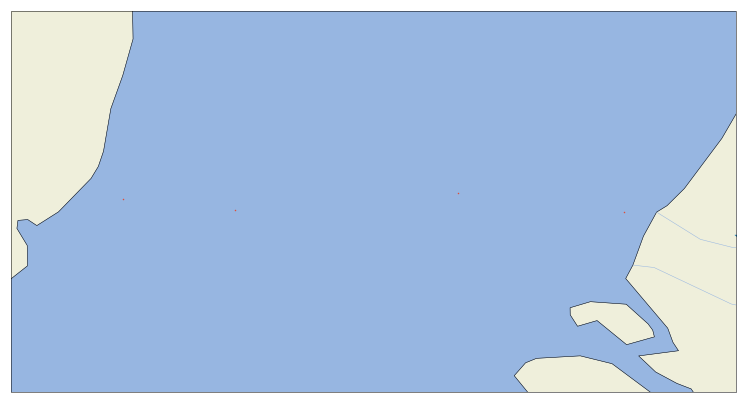

In [51]:
aismap.plot_to_map(size = (13, 13), longitude = pd.Series(lons), latitude = pd.Series(lats))

In [56]:
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 10, algorithm= 'kd_tree', weights= 'distance', leaf_size= 30)
    scores = cross_val_score(knn_time, X[s], y[s]['sector_leave_lat'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))

0 -> -0.025594
1 -> -0.058227
2 -> -0.003658


In [57]:
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 5, algorithm= 'kd_tree', weights= 'distance', leaf_size= 30)
    scores = cross_val_score(knn_time, X[s], y[s]['sector_leave_lat'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))

0 -> -0.026081
1 -> -0.061139
2 -> -0.003733


In [52]:
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 10, algorithm= 'kd_tree', weights= 'distance', leaf_size= 30)
    scores = cross_val_score(knn_time, X[s], y[s]['mins_to_sector_leave'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))

0 -> -11.253571
1 -> -13.020298
2 -> -10.696820


In [55]:
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 5, algorithm= 'kd_tree', weights= 'distance', leaf_size= 30)
    scores = cross_val_score(knn_time, X[s], y[s]['mins_to_sector_leave'], cv = cv_splits[s], scoring = 'neg_mean_absolute_error')
    print("%d -> %f" % (s, scores.mean()))

0 -> -11.309401
1 -> -12.692429
2 -> -10.761773


In [58]:
knn_time_list = []
for s in sectors:
    knn_time = KNeighborsRegressor(n_neighbors = 5, algorithm= 'kd_tree', weights= 'distance', leaf_size= 30)
    knn_time.fit(X_train[s], y_train[s]['mins_to_sector_leave'])
    knn_time_list.append(knn_time)

In [ ]:
knn_time_list[1].predict([[51.93, 1.3]])[0]

In [63]:
# Pickle KNN models
import pickle

for s in sectors:
    pos_model = knn_pos_list[s]
    pickle.dump(pos_model, open('../App/Agents/fel_rot_s%d/model_position.pkl' % (s), 'wb'))
    
    time_model = knn_time_list[s]
    pickle.dump(time_model, open('../App/Agents/fel_rot_s%d/model_time.pkl' % (s), 'wb'))
    
    course_model = knn_course_list[s]
    pickle.dump(course_model, open('../App/Agents/fel_rot_s%d/model_cog.pkl' % (s), 'wb'))
    
    speed_model = knn_speed_list[s]
    pickle.dump(speed_model, open('../App/Agents/fel_rot_s%d/model_sog.pkl' % (s), 'wb'))

In [60]:


time_model = knn_time_list[1]
pickle.dump(time_model, open('../App/Agents/fel_rot_s%d/model_time.pkl' % (1), 'wb'))

In [26]:
test_loaded = pickle.load(open('../App/Agents/fel_rot_s%d/model_time.pkl' % (1), 'rb'))
test_loaded.predict([[51.93, 1.3]])[0]

167.27650257601084

In [ ]:
print(knn_time_list[2])
print(test_loaded)